# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [75]:
!pip install datasets

Импорт необходимых библиотек

In [76]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List, Tuple
import string
import random
import os

import seaborn
seaborn.set(palette='summer')

In [77]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Фиксация результатов

In [79]:
def seed_torch(seed: int=42):

  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [80]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [81]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

vocab = list(vocab)
print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [82]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [83]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [84]:
def evaluate(model) -> float: # Просто хотим считать accuracy на валидационном датасете
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad(): # чтобы не считать градиенты на валидации, пользуемся no_grad()
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# **1. Запуск базовой модели с семинара**

## 1.1 Вспомогательные функции

In [85]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ): # передается скрытая размерность, размер словаря, количество классов предсказания и тип аггрегирования
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim) # Храним матрицу эмбеддингов. Это матрица, которая в каждой строке хранит вектор соответствующему слову в словаре.
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True) # RNN  модуль. Подается входная и выходная скрытая размерность
        self.linear = nn.Linear(hidden_dim, hidden_dim) # Линейный слой
        self.projection = nn.Linear(hidden_dim, num_classes) # Из скрытой размерности проектирует количество классов

        self.non_lin = nn.Tanh() # Функция активации - гиперболический тангенс
        self.dropout = nn.Dropout(p=0.1) # Дропаут слой с вероятностью 0.1

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max': # Maxpooling агрегация. Берем по первой размерности (seq_len) берем максимум всех векторов и берем 0 элемент (т.к. нужны значения)
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean': # Берем средней по первой размерности
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [86]:
def training(model, train_dataloader, eval_dataloader, num_epoch:int = 5):
  eval_steps = len(train_dataloader) // 2

  losses = []
  acc = []

  seed_torch()
  model = model
  seed_torch()
  criterion = nn.CrossEntropyLoss()
  seed_torch()
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
    epoch_losses = []
    model.train()

    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
      optimizer.zero_grad()
      logits = model(batch['input_ids'])
      loss = criterion(logits, batch['label'])
      loss.backward()
      optimizer.step()

      epoch_losses.append(loss.item())
      if i % eval_steps == 0:
        model.eval()
        acc.append(evaluate(model))
        model.train()
    losses.append(sum(epoch_losses) / len(epoch_losses))

  return losses, acc

In [87]:
def plotting(losses, acc):

  for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

  plt.title('Losses')
  plt.xlabel("epoch")
  plt.legend()
  plt.show()

  for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

  plt.title('Accuracy')
  plt.xlabel("epoch")
  plt.legend()
  plt.show()

## 1.2 Обучение и результаты

In [88]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    seed_torch()
    print(f'Starting for {aggregation_type}')
    model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)

Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

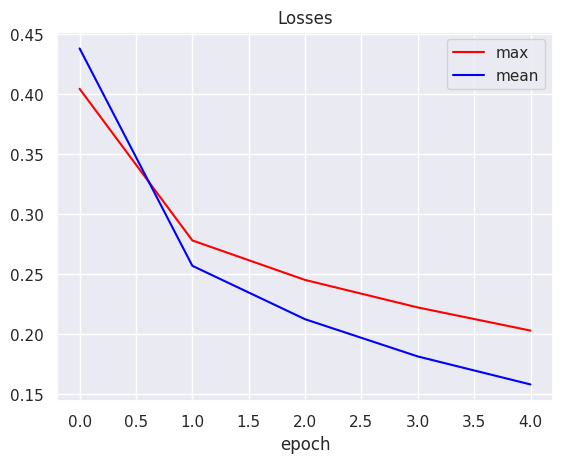

Лучшая accuracy для подхода max: 90.46
Лучшая accuracy для подхода mean: 90.74


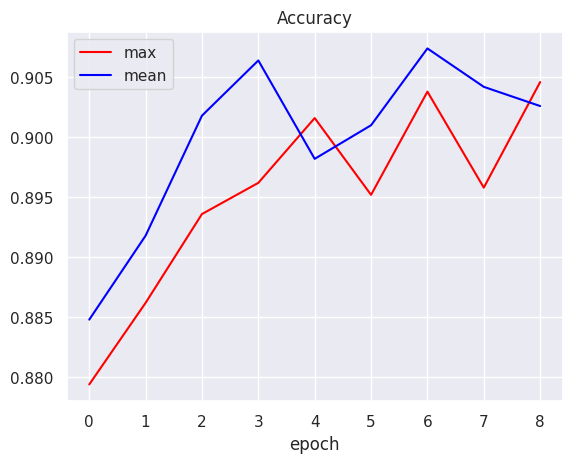

In [89]:
plotting(losses_type, acc_type)

# **2. Эксперименты**

## 2.1 Модель RNN. Использование GRU

In [90]:
class CharLM_GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ): # передается скрытая размерность, размер словаря, количество классов предсказания и тип аггрегирования
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim) # Храним матрицу эмбеддингов. Это матрица, которая в каждой строке хранит вектор соответствующему слову в словаре.
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True) # GRU  модуль. Подается входная и выходная скрытая размерность
        self.linear = nn.Linear(hidden_dim, hidden_dim) # Линейный слой
        self.projection = nn.Linear(hidden_dim, num_classes) # Из скрытой размерности проектирует количество классов

        self.non_lin = nn.Tanh() # Функция активации - гиперболический тангенс
        self.dropout = nn.Dropout(p=0.1) # Дропаут слой с вероятностью 0.1

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max': # Maxpooling агрегация. Берем по первой размерности (seq_len) берем максимум всех векторов и берем 0 элемент (т.к. нужны значения)
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean': # Берем средней по первой размерности
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [91]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    seed_torch()
    print(f'Starting for {aggregation_type}')
    model = CharLM_GRU(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)

Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

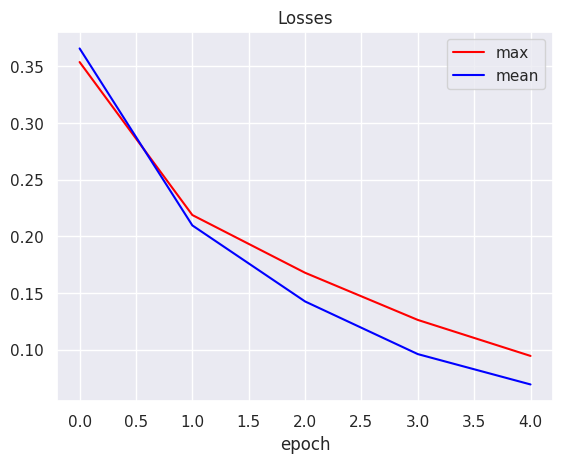

Лучшая accuracy для подхода max: 91.40
Лучшая accuracy для подхода mean: 91.30


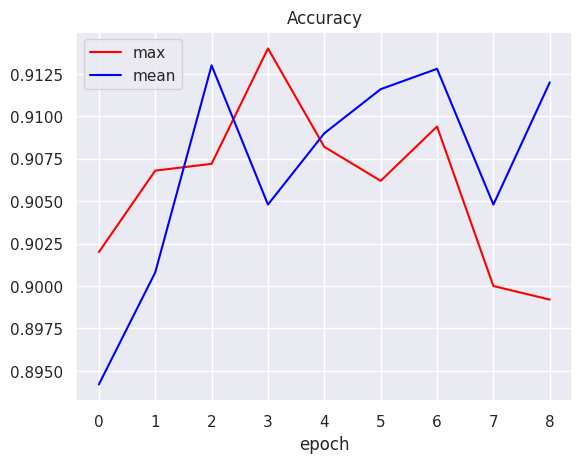

In [92]:
plotting(losses_type, acc_type)

## 2.2 Увеличение количества рекуррентных слоев модели

In [93]:
class CharLM_layers(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ): # передается скрытая размерность, размер словаря, количество классов предсказания и тип аггрегирования
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim) # Храним матрицу эмбеддингов. Это матрица, которая в каждой строке хранит вектор соответствующему слову в словаре.
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=2) # RNN  модуль. Подается входная и выходная скрытая размерность + количество слоев
        self.linear = nn.Linear(hidden_dim, hidden_dim) # Линейный слой
        self.projection = nn.Linear(hidden_dim, num_classes) # Из скрытой размерности проектирует количество классов

        self.non_lin = nn.Tanh() # Функция активации - гиперболический тангенс
        self.dropout = nn.Dropout(p=0.1) # Дропаут слой с вероятностью 0.1

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max': # Maxpooling агрегация. Берем по первой размерности (seq_len) берем максимум всех векторов и берем 0 элемент (т.к. нужны значения)
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean': # Берем средней по первой размерности
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [94]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    seed_torch()
    print(f'Starting for {aggregation_type}')
    model = CharLM_layers(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)

Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

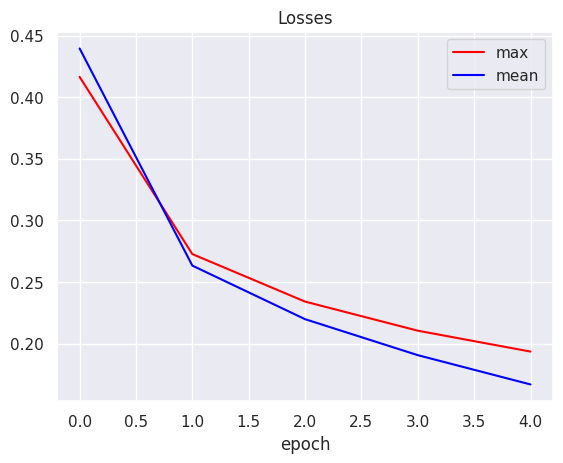

Лучшая accuracy для подхода max: 91.32
Лучшая accuracy для подхода mean: 90.60


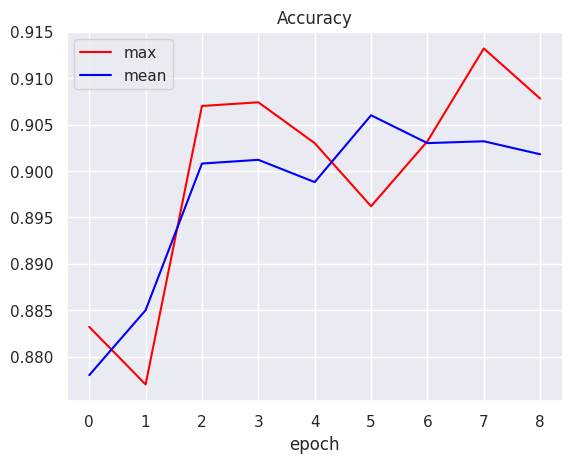

In [95]:
plotting(losses_type, acc_type)

## 2.3.1 Изменение количества эпох

Num epoch is equal: 7
----------
Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Finish for 7 epoch


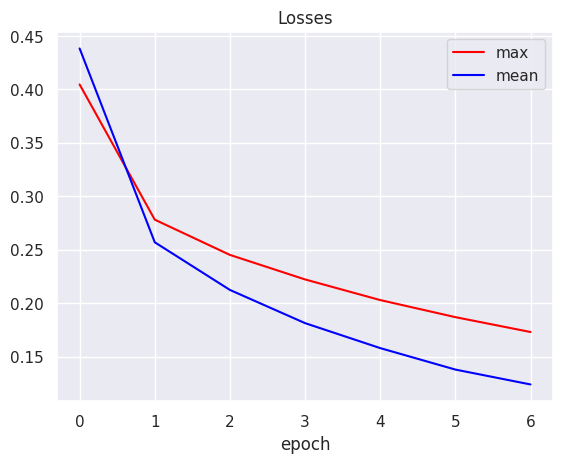

Лучшая accuracy для подхода max: 90.56
Лучшая accuracy для подхода mean: 90.74


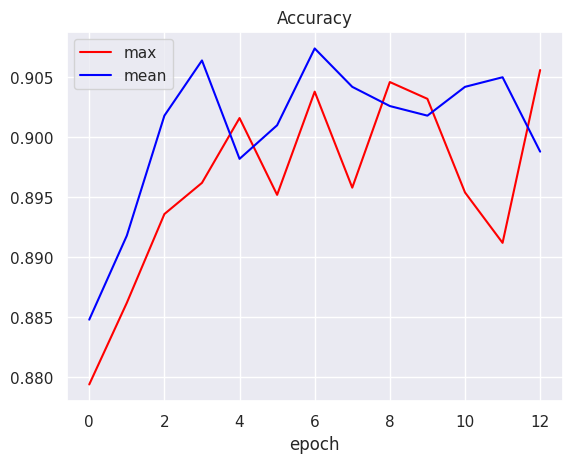

----------

Num epoch is equal: 10
----------
Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Finish for 10 epoch


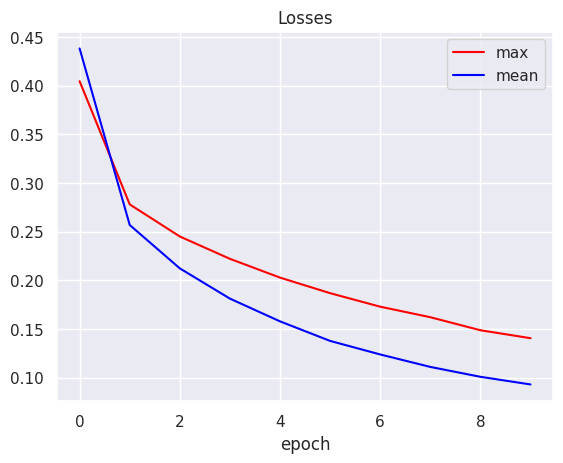

Лучшая accuracy для подхода max: 90.68
Лучшая accuracy для подхода mean: 90.74


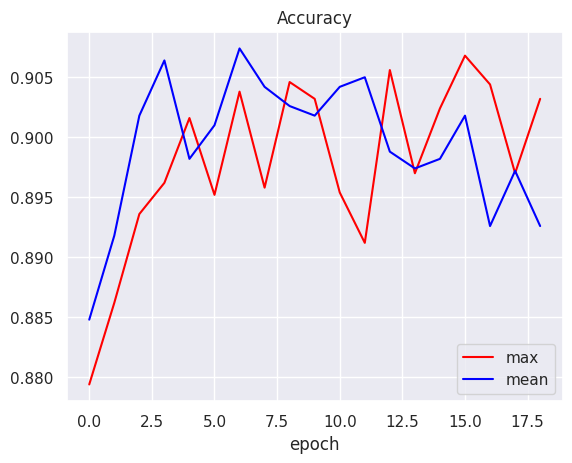

----------



In [96]:
for n_epoch in [7,10]:

  print(f'Num epoch is equal: {n_epoch}')
  print('----------')
  losses_type = {}
  acc_type = {}
  for aggregation_type in ['max', 'mean']:
      seed_torch()
      print(f'Starting for {aggregation_type}')
      model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
      losses_type[aggregation_type], acc_type[aggregation_type] = training(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=n_epoch)
  print(f'Finish for {n_epoch} epoch')
  plotting(losses_type, acc_type)
  print('----------')
  print()

## 2.3.2 Изменение вероятности дропаута

In [97]:
class CharLM_p(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', p: float = 0.1
        ): # передается скрытая размерность, размер словаря, количество классов предсказания и тип аггрегирования
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim) # Храним матрицу эмбеддингов. Это матрица, которая в каждой строке хранит вектор соответствующему слову в словаре.
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True) # RNN  модуль. Подается входная и выходная скрытая размерность
        self.linear = nn.Linear(hidden_dim, hidden_dim) # Линейный слой
        self.projection = nn.Linear(hidden_dim, num_classes) # Из скрытой размерности проектирует количество классов

        self.non_lin = nn.Tanh() # Функция активации - гиперболический тангенс
        self.dropout = nn.Dropout(p=p) # Дропаут слой с вероятностью 0.1

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max': # Maxpooling агрегация. Берем по первой размерности (seq_len) берем максимум всех векторов и берем 0 элемент (т.к. нужны значения)
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean': # Берем средней по первой размерности
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

P Dropout is equal: 0.05
----------
Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Finish for 0.05 p dropout


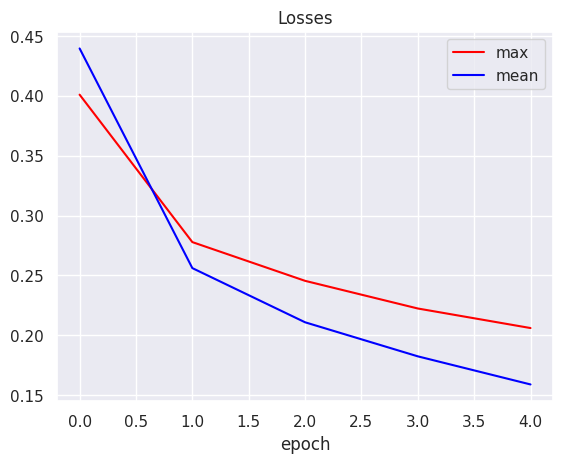

Лучшая accuracy для подхода max: 90.50
Лучшая accuracy для подхода mean: 90.48


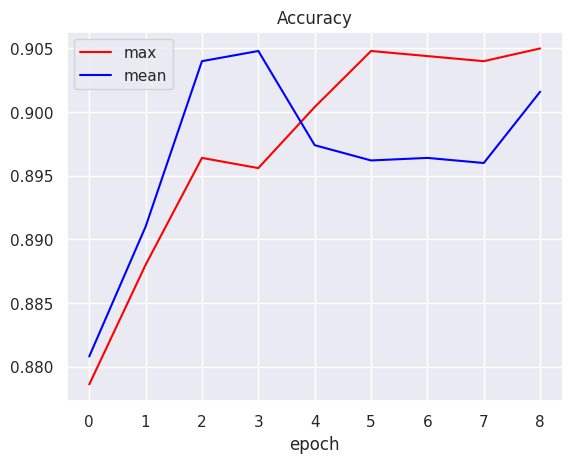

----------

P Dropout is equal: 0.07
----------
Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Finish for 0.07 p dropout


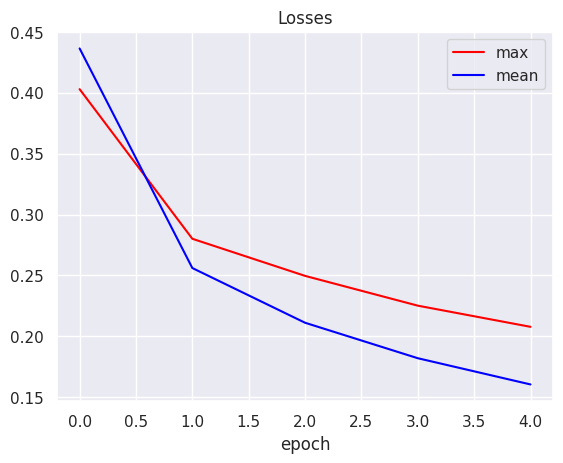

Лучшая accuracy для подхода max: 90.08
Лучшая accuracy для подхода mean: 90.44


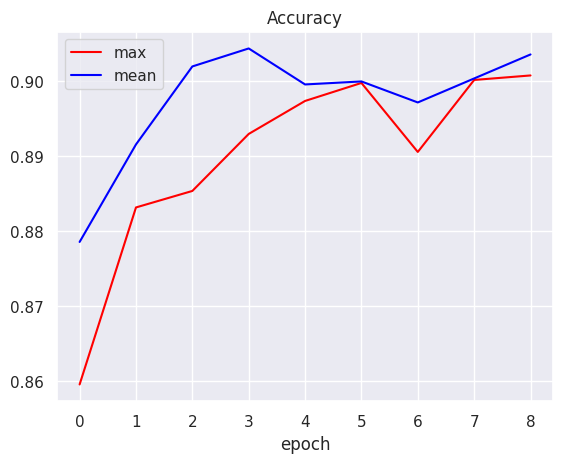

----------



In [98]:
for p_dropout in [0.05,0.07]:

  print(f'P Dropout is equal: {p_dropout}')
  print('----------')
  losses_type = {}
  acc_type = {}
  for aggregation_type in ['max', 'mean']:
      seed_torch()
      print(f'Starting for {aggregation_type}')
      model = CharLM_p(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type, p = p_dropout).to(device)
      losses_type[aggregation_type], acc_type[aggregation_type] = training(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)
  print(f'Finish for {p_dropout} p dropout')
  plotting(losses_type, acc_type)
  print('----------')
  print()

## 2.4 Изменение архитектуры после применения RNN. Добавление линейных слоев сети

In [99]:
class CharLM_linears(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ): # передается скрытая размерность, размер словаря, количество классов предсказания и тип аггрегирования
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim) # Храним матрицу эмбеддингов. Это матрица, которая в каждой строке хранит вектор соответствующему слову в словаре.
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True) # RNN  модуль. Подается входная и выходная скрытая размерность
        self.f_linear = nn.Linear(hidden_dim, 32) # Первый линейный слой
        self.s_linear = nn.Linear(32, 32) # Второй линейный слой
        self.projection = nn.Linear(32, num_classes) # Из скрытой размерности проектирует количество классов

        self.non_lin = nn.Tanh() # Функция активации - гиперболический тангенс
        self.dropout = nn.Dropout(p=0.1) # Дропаут слой с вероятностью 0.1

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max': # Maxpooling агрегация. Берем по первой размерности (seq_len) берем максимум всех векторов и берем 0 элемент (т.к. нужны значения)
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean': # Берем средней по первой размерности
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        f_output = self.dropout(self.f_linear(self.non_lin(output)))
        s_output = self.dropout(self.s_linear(self.non_lin(f_output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(s_output))  # [batch_size, num_classes]

        return prediction

In [100]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    seed_torch()
    print(f'Starting for {aggregation_type}')
    model = CharLM_linears(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)

Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

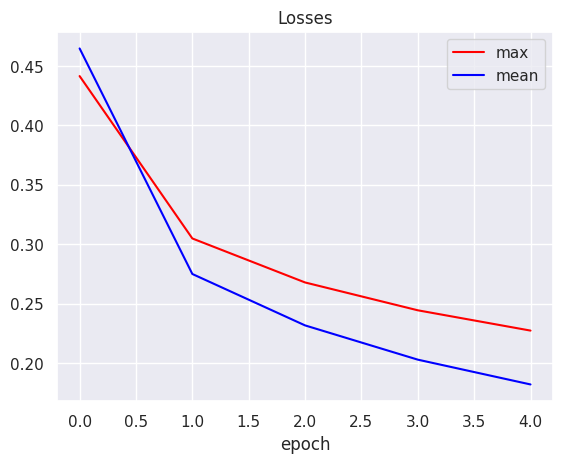

Лучшая accuracy для подхода max: 90.36
Лучшая accuracy для подхода mean: 90.46


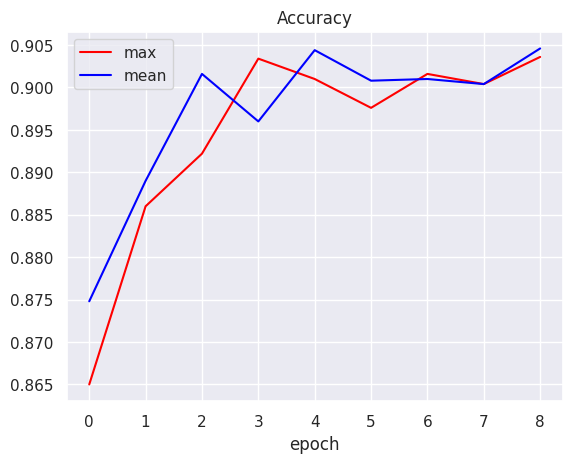

In [101]:
plotting(losses_type, acc_type)

# **3. Выбор лучшего эксперимента и комбинация методов**

In [102]:
class CharLM_GRU_best(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ): # передается скрытая размерность, размер словаря, количество классов предсказания и тип аггрегирования
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim) # Храним матрицу эмбеддингов. Это матрица, которая в каждой строке хранит вектор соответствующему слову в словаре.
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=2) # GRU  модуль. Подается входная и выходная скрытая размерность
        self.linear = nn.Linear(hidden_dim, hidden_dim) # Линейный слой
        self.projection = nn.Linear(hidden_dim, num_classes) # Из скрытой размерности проектирует количество классов

        self.non_lin = nn.Tanh() # Функция активации - гиперболический тангенс
        self.dropout = nn.Dropout(p=0.1) # Дропаут слой с вероятностью 0.1

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max': # Maxpooling агрегация. Берем по первой размерности (seq_len) берем максимум всех векторов и берем 0 элемент (т.к. нужны значения)
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean': # Берем средней по первой размерности
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [103]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    seed_torch()
    print(f'Starting for {aggregation_type}')
    model = CharLM_GRU_best(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=7)

Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

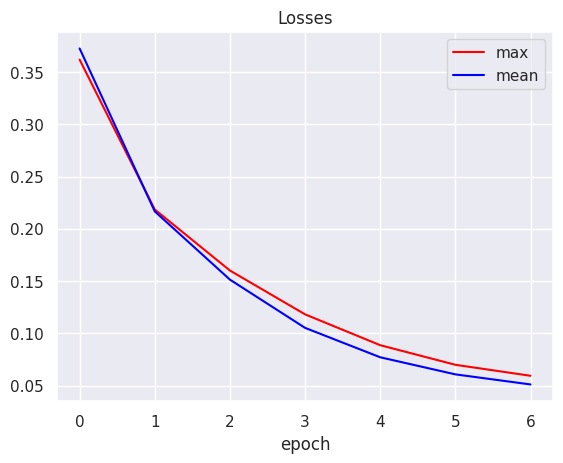

Лучшая accuracy для подхода max: 91.98
Лучшая accuracy для подхода mean: 91.56


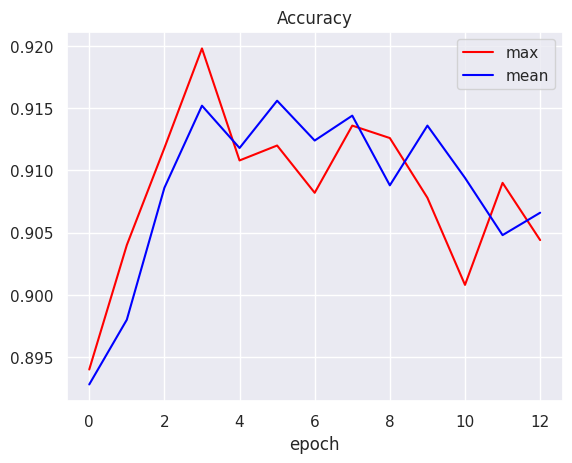

In [104]:
plotting(losses_type, acc_type)

# **4. Отчет**

* Для фиксации результатов были зафиксированы все возможные seed
* Удален атрибут "ignore_index=word2ind['<pad>']" из функции потерь

---
Были проведены несколько экспериментов в параграфе 2:

1) Изменение сети с RNN на GRU;

2) Изменение количество слоев в RNN на num_layers = 2;

3) Подборы гиперпараметров, а именно:
  * Количество эпох 7 и 10;
  * Вероятность dropout 0.05 и 0.07;

4) Изменение архитектуры после RNN. Линейный слой был разделен на два линейных один из которых переводит сеть из размера скрытого слоя в размер 32, второй из размера 32 в 32.

---
Итоги: Базовые значения для аггрегаций max и mean равны 90.46 и 90.74 соответственно!

1) Использование сети GRU приводит к повышению метрики Accuracy для обоих видов аггрегации max и mean до 91.40 и 91.30 соответственно;

2) Изменение количество слоев приводит понижению метрики Accuracy для обоих видов аггрегации max и mean до 91.32 и 90.60 соответственно;

3)
* 7 эпох acc(max) = 90.56, acc(mean) = 90.74;
* 10 эпох acc(max) = 90.68, acc(mean) = 90.74;
* 0.05 dropout acc(max) = 90.50, acc(mean) = 90.48;
* 0.07 dropout acc(max) = 90.08, acc(mean) = 90.44.

**ИТОГ:** При увеличении значения эпох, метрики возрастают, однако возрастает и время обучения. При уменьшении вероятности dropout метрика при max аггрегации падает, а для mean аггрегации растет

4) Изменение архитектуры после RNN, а именно добавление линейного слоя приводит понижению метрики Accuracy для обоих видов аггрегации max и mean до 90.36 и 90.46 соответственно.

*По графикам сходимости можно увидеть, что в начале эпох агрегация типа max показывает в среднем значение выше относительно mean, однако на большем значении эпох картина меняется. Также можно заметить, что на больших значениях эпох метрика ведет себя менее стабильно и начинает колебаться (в сети GRU это видно отчетливо)*

---

## Итоговой моделью была выбрана:
* Сеть - GRU
* Количество слоев - 2
* Количество эпох - 7
* Вероятность Dropout - 0.1

## Значение метрики Accuracy best model:
* Max aggregation = 91.98
* Mean aggreagtion = 91.56
